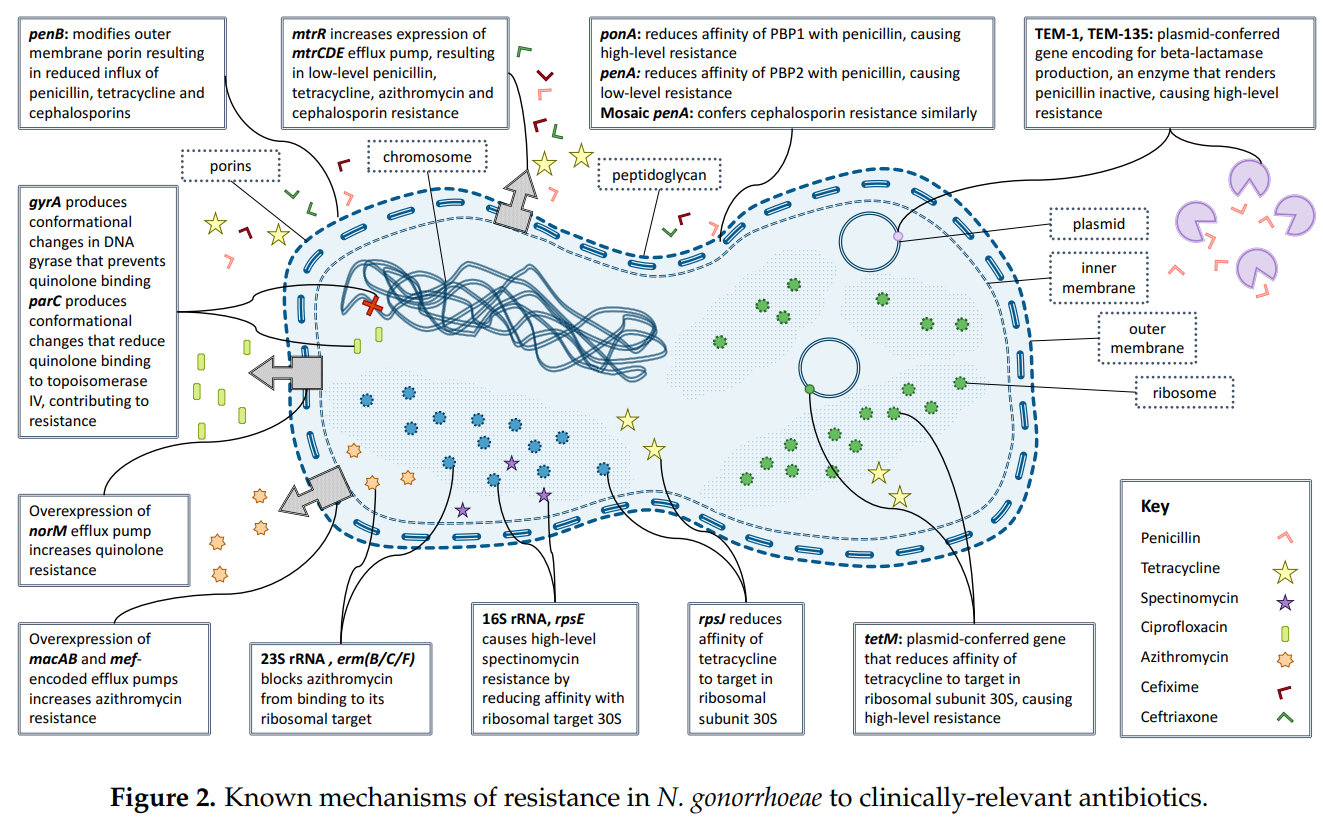

In [2]:
import pandas as pd
import numpy as np

from sklearn.model_selection import KFold
from sklearn.model_selection import GroupKFold
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import confusion_matrix
from sklearn.metrics import balanced_accuracy_score
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit

import matplotlib.pyplot as plt
import seaborn as sb
import time

import warnings
warnings.filterwarnings("ignore")

**Unitigs**, short stretches of DNA can be made by 
DBGWAS methods

In [3]:
def prep_data(phenotype) :
    pheno = pd.read_csv('/content/metadata.csv', index_col=0)
    pheno = pheno.dropna(subset=[phenotype])
    pheno = pheno[phenotype]
        
    
    X = pd.read_csv('/content/' + phenotype + '_gwas_filtered_unitigs.Rtab', sep=" ", index_col=0, low_memory=False)
    X = X.transpose()
    X = X[X.index.isin(pheno.index)]
    pheno = pheno[pheno.index.isin(X.index)]
    return X, pheno

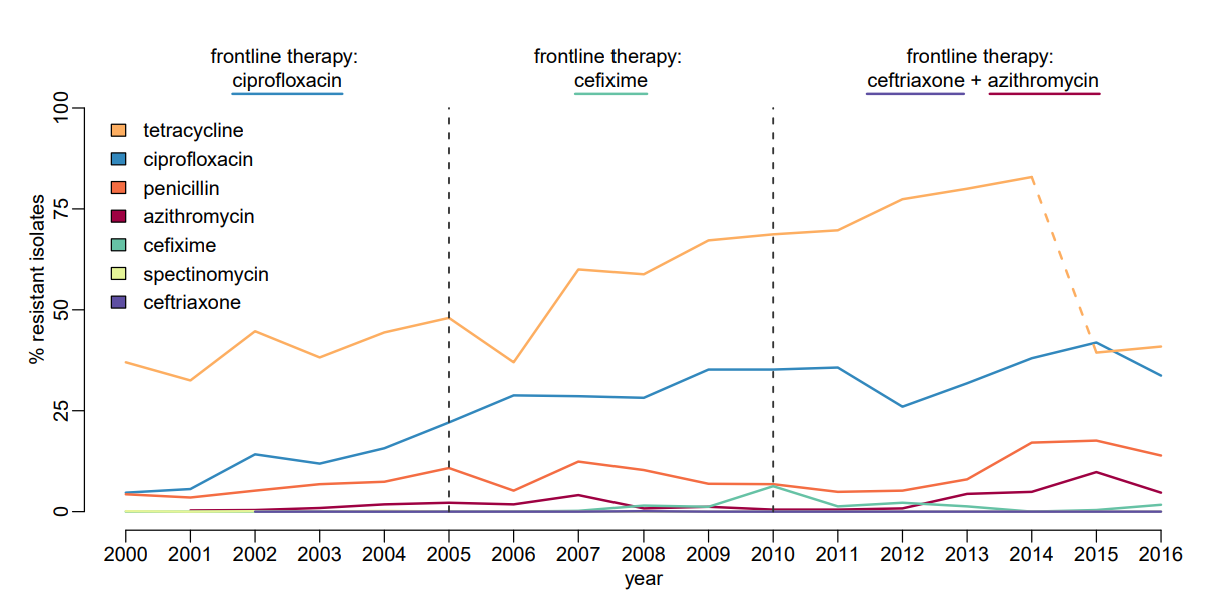

First, phenotype is Azithromycin resistance 

In [4]:
phenotype = 'azm_sr'
X, pheno = prep_data(phenotype)

performance = []
method = []
times = []

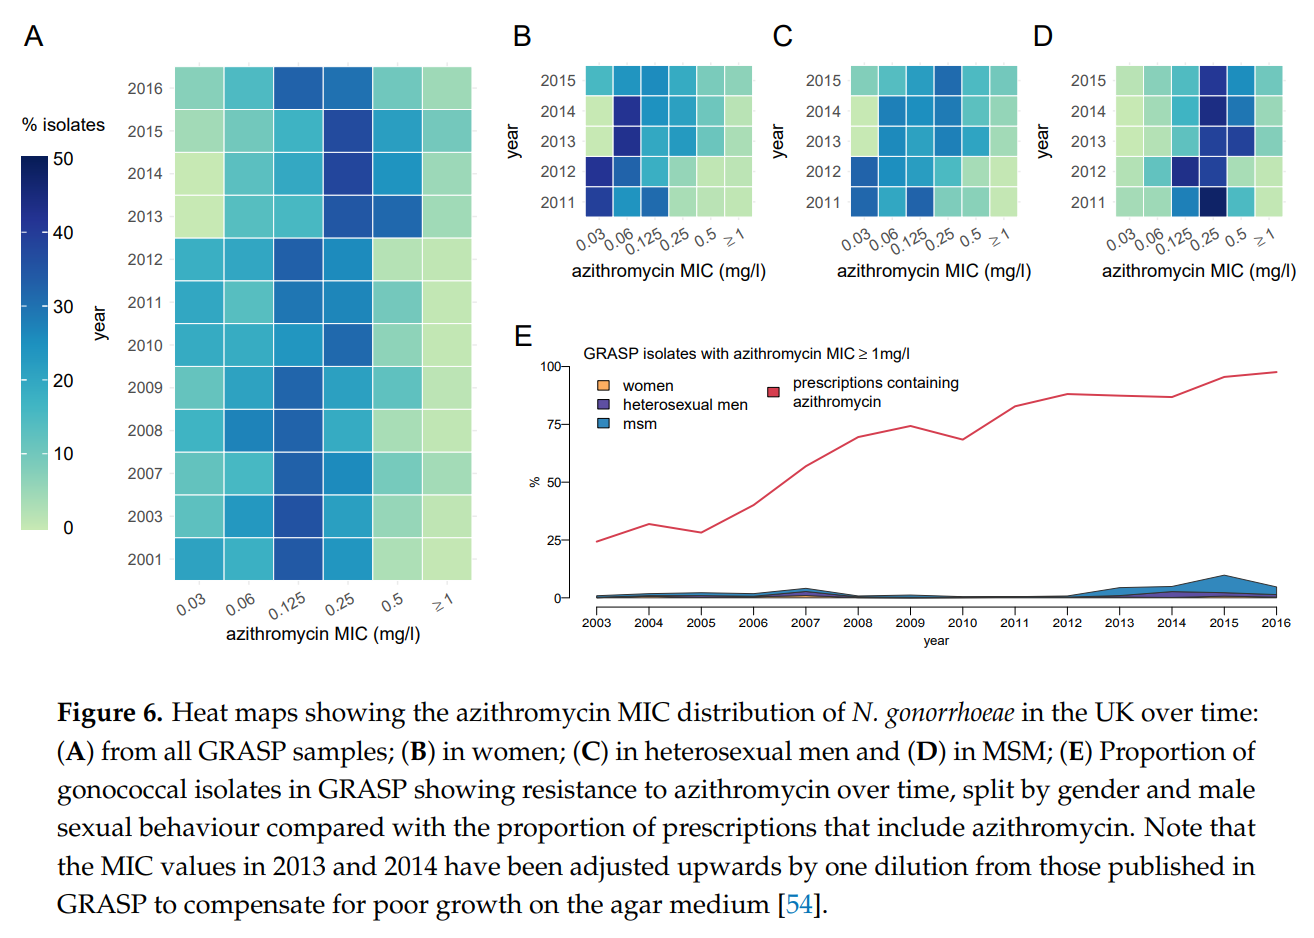

Exploring the data

In [5]:
print(pheno.shape)
print(pheno)

print(X.shape)
print(X.iloc[:10,:10])

(3478,)
Sample_ID
ERR1549286    1.0
ERR1549290    1.0
ERR1549291    1.0
ERR1549287    1.0
ERR1549288    1.0
             ... 
ERR2172350    1.0
ERR2172351    1.0
ERR2172352    1.0
ERR2172353    1.0
ERR2172354    0.0
Name: azm_sr, Length: 3478, dtype: float64
(3478, 515)
pattern_id  CTTAACATATTTGCCTTTGATTTTTGAAGAAGCTGCCACGCCGGCAG  \
ERR1549286                                                0   
ERR1549290                                                0   
ERR1549291                                                0   
ERR1549287                                                0   
ERR1549288                                                0   
ERR1549299                                                0   
ERR1549292                                                0   
ERR1549298                                                0   
ERR1549296                                                0   
ERR1549300                                                0   

pattern_id  TACCGTAACCGGCAATGCGGATA

The length distribution of the unitigs in our dataset

Index(['CTTAACATATTTGCCTTTGATTTTTGAAGAAGCTGCCACGCCGGCAG',
       'TACCGTAACCGGCAATGCGGATATTACGGTC', 'CAGACGGCATTTTTTTTGCGTTTTTCGGGAGG',
       'AACGGGTTTTCAGACGGCATTCGATATCGGGACG',
       'CCAAAAATTACCCGCGTTGACGTAGCTAAAGA',
       'CGGACCGGTATTCCGTCGAAATCACCGCCGTCAACCGCCCC',
       'TGAAATTGTCCATCTCGTATGCCGTCTTCTGCTTG',
       'TACGGTATTGTCCGCATTATTAAACTCAAAACC,AGAAGACGGCATACGAGATGGACAATTTCATCC',
       'GGCATTTTTTTTGCGTTTTTCGGGAGGGGGCGGC',
       'TATATAAGGGGTTGCCGTTCCGCAGTTGGGCGGCAGCATAC'],
      dtype='object', name='pattern_id')


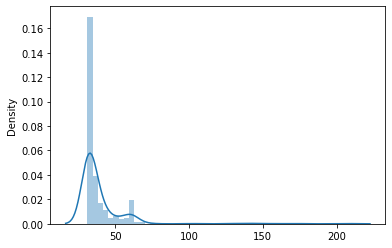

In [6]:
unitigs = X.columns
print(unitigs[:10])
mylen = np.vectorize(len)
uni_len = mylen(unitigs)
sb.distplot(uni_len)

-Building and fitting a model

-call all samples with a predicted value less than or equal to 0.5 as sensitive to the antibiotic

-samples with predicted value >0.5 resistant to the antibiotic

In [7]:
def fitmodel(X, pheno, estimator, parameters, modelname, method, performance, times) :
    
    kfold = KFold(n_splits=5)
    for train_index, test_index in kfold.split(X, pheno):
        #how much time for training
        start = time.process_time()
        
        #splitting data
        X_train = X.iloc[train_index]
        y_train = pheno[train_index]
        X_test = X.iloc[test_index]
        y_test = pheno[test_index]
        
        # grid search to identify best hyper-parameters
        gs_clf = GridSearchCV(estimator=estimator, param_grid=parameters, cv=3, n_jobs=-1, scoring='balanced_accuracy')
        gs_clf.fit(X_train, y_train)
        
        # predict resistance in test
        y_pred = gs_clf.predict(X_test)
        
        y_pred[y_pred<=0.5] = 0
        y_pred[y_pred>0.5] = 1

        score = balanced_accuracy_score(y_test, y_pred)
        performance = np.append(performance, score)
        method = np.append(method, modelname)
        times = np.append(times, (time.process_time() - start))

        print("Best hyperparameters for this fold")
        print(gs_clf.best_params_)
        print("Confusion matrix for this fold")
        print(confusion_matrix(y_test, y_pred))
    return gs_clf, method, performance, times

In [8]:
def sbplot(X, pheno, estimator, parameters, modelname, method, performance, times) :
    results = []
    
    kfold = KFold(n_splits=5)
    for train_index, test_index in kfold.split(X, pheno):
        start = time.process_time()
        
      
        X_train = X.iloc[train_index]
        y_train = pheno[train_index]
        X_test = X.iloc[test_index]
        y_test = pheno[test_index]
        
      
        gs_clf = GridSearchCV(estimator=estimator, param_grid=parameters, cv=3, n_jobs=-1, scoring='balanced_accuracy')
        gs_clf.fit(X_train, y_train)
        
      
        y_pred = gs_clf.predict(X_test)
        
        results.append([y_test, y_pred])
        
    return results

First we will try an elastic net logistic regression.

In [9]:
enet = SGDClassifier(loss="log", penalty="elasticnet")
enet_params = {
    'l1_ratio': [0.1, 0.2, 0.5]
}

enet_model, method, performance, times = fitmodel(X, pheno, enet, enet_params, "Elastic net", method, performance, times)

Best hyperparameters for this fold
{'l1_ratio': 0.5}
Confusion matrix for this fold
[[534  16]
 [ 36 110]]
Best hyperparameters for this fold
{'l1_ratio': 0.1}
Confusion matrix for this fold
[[687   1]
 [  1   7]]
Best hyperparameters for this fold
{'l1_ratio': 0.5}
Confusion matrix for this fold
[[643   6]
 [ 10  37]]
Best hyperparameters for this fold
{'l1_ratio': 0.2}
Confusion matrix for this fold
[[568  57]
 [  9  61]]
Best hyperparameters for this fold
{'l1_ratio': 0.2}
Confusion matrix for this fold
[[499  20]
 [ 12 164]]


Giving support vector machine a try

In [10]:
svm = SVC(class_weight='balanced')
svm_params = {
    'C': [0.01],
    'gamma': [1e-06, 1e-05],
    'kernel': ['linear']
}

svm_model, method, performance, times = fitmodel(X, pheno, svm, svm_params, "Support vector machine", method, performance, times)

Best hyperparameters for this fold
{'C': 0.01, 'gamma': 1e-06, 'kernel': 'linear'}
Confusion matrix for this fold
[[538  12]
 [ 15 131]]
Best hyperparameters for this fold
{'C': 0.01, 'gamma': 1e-06, 'kernel': 'linear'}
Confusion matrix for this fold
[[687   1]
 [  0   8]]
Best hyperparameters for this fold
{'C': 0.01, 'gamma': 1e-06, 'kernel': 'linear'}
Confusion matrix for this fold
[[638  11]
 [  2  45]]
Best hyperparameters for this fold
{'C': 0.01, 'gamma': 1e-06, 'kernel': 'linear'}
Confusion matrix for this fold
[[590  35]
 [  5  65]]
Best hyperparameters for this fold
{'C': 0.01, 'gamma': 1e-06, 'kernel': 'linear'}
Confusion matrix for this fold
[[505  14]
 [  6 170]]


Now we will try XGBoost.

In [11]:
xgb_mod = xgb.XGBClassifier(random_state=0)
xgb_params = {
    'alpha': [1e-5, 1e-4], 
    'colsample_bytree': [0.6],
    'gamma': [0.05, 0.1], 
    'learning_rate': [0.01, 0.1], 
    'max_depth': [2], 
    'objective': ['binary:hinge'], 
    'subsample': [0.2, 0.4, 0.6]
}

xgb_model, method, performance, times = fitmodel(X, pheno, xgb_mod, xgb_params, "XGBoost", method, performance, times)

Best hyperparameters for this fold
{'alpha': 1e-05, 'colsample_bytree': 0.6, 'gamma': 0.05, 'learning_rate': 0.01, 'max_depth': 2, 'objective': 'binary:hinge', 'subsample': 0.4}
Confusion matrix for this fold
[[536  14]
 [ 15 131]]
Best hyperparameters for this fold
{'alpha': 1e-05, 'colsample_bytree': 0.6, 'gamma': 0.05, 'learning_rate': 0.01, 'max_depth': 2, 'objective': 'binary:hinge', 'subsample': 0.2}
Confusion matrix for this fold
[[686   2]
 [  0   8]]
Best hyperparameters for this fold
{'alpha': 1e-05, 'colsample_bytree': 0.6, 'gamma': 0.05, 'learning_rate': 0.01, 'max_depth': 2, 'objective': 'binary:hinge', 'subsample': 0.2}
Confusion matrix for this fold
[[636  13]
 [  2  45]]
Best hyperparameters for this fold
{'alpha': 1e-05, 'colsample_bytree': 0.6, 'gamma': 0.05, 'learning_rate': 0.01, 'max_depth': 2, 'objective': 'binary:hinge', 'subsample': 0.4}
Confusion matrix for this fold
[[590  35]
 [  5  65]]
Best hyperparameters for this fold
{'alpha': 1e-05, 'colsample_bytree': 

And finally, a random forest.

In [12]:
rf = RandomForestClassifier(random_state=0, n_jobs=-1, class_weight="balanced")
rf_params = {
    'max_features': [round(X.shape[1]*0.1), round(X.shape[1]*0.5), round(X.shape[1]*0.8)],
    'max_depth': [3],
    'n_estimators': [50]
}

rf_model, method, performance, times = fitmodel(X, pheno, rf, rf_params, "Random forest", method, performance, times)

Best hyperparameters for this fold
{'max_depth': 3, 'max_features': 412, 'n_estimators': 50}
Confusion matrix for this fold
[[538  12]
 [ 15 131]]
Best hyperparameters for this fold
{'max_depth': 3, 'max_features': 258, 'n_estimators': 50}
Confusion matrix for this fold
[[681   7]
 [  0   8]]
Best hyperparameters for this fold
{'max_depth': 3, 'max_features': 258, 'n_estimators': 50}
Confusion matrix for this fold
[[637  12]
 [  2  45]]
Best hyperparameters for this fold
{'max_depth': 3, 'max_features': 258, 'n_estimators': 50}
Confusion matrix for this fold
[[588  37]
 [  5  65]]
Best hyperparameters for this fold
{'max_depth': 3, 'max_features': 258, 'n_estimators': 50}
Confusion matrix for this fold
[[505  14]
 [  6 170]]


compare results from the different predictors

(array([0, 1, 2, 3]), <a list of 4 Text major ticklabel objects>)

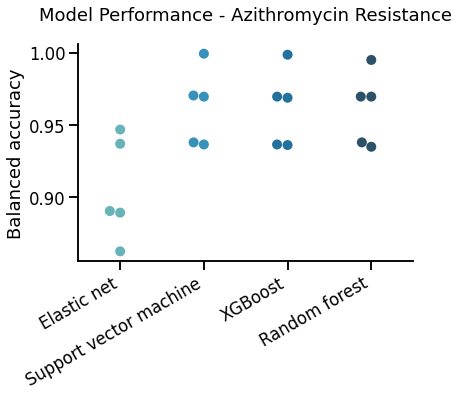

In [13]:
sb.set_context("talk")
plt.title("Model Performance - Azithromycin Resistance", y=1.08)
sb.swarmplot(x=method, y=performance, palette="YlGnBu_d", size=10)
sb.despine()
plt.ylabel("Balanced accuracy")
plt.xticks(rotation=30, ha='right')

time taken to train the different models

(array([0, 1, 2, 3]), <a list of 4 Text major ticklabel objects>)

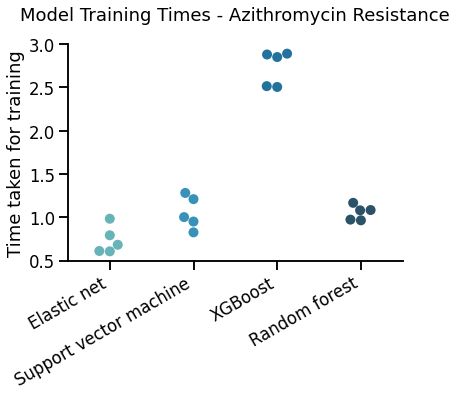

In [14]:
sb.set_context("talk")
plt.title("Model Training Times - Azithromycin Resistance", y=1.08)
sb.swarmplot(x=method, y=times, palette="YlGnBu_d", size=10)
sb.despine()
plt.ylabel("Time taken for training")
plt.xticks(rotation=30, ha='right')

looking at SVM feature importance

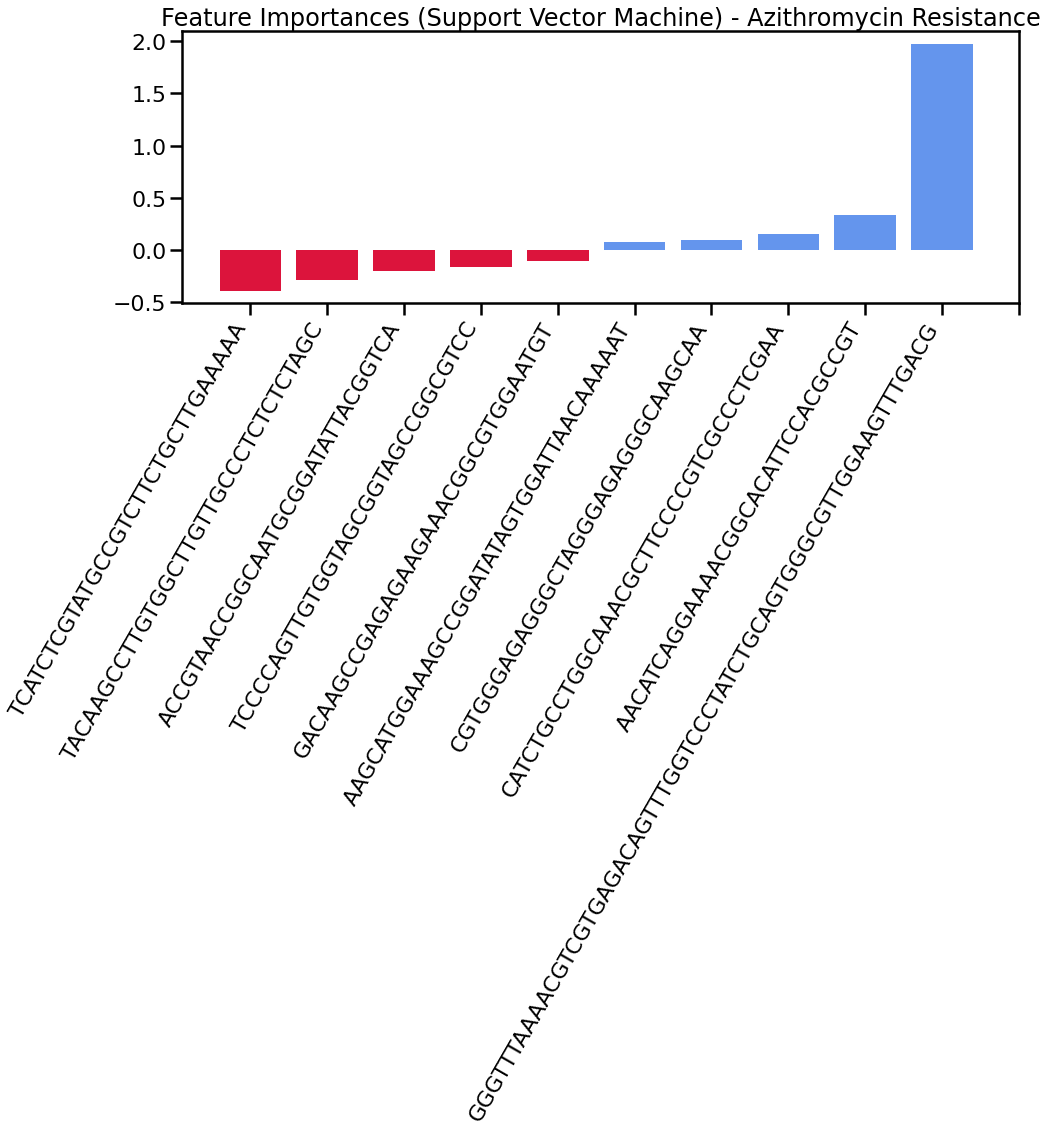

Top negative predictors:  ['TCATCTCGTATGCCGTCTTCTGCTTGAAAAA' 'TACAAGCCTTGTGGCTTGTTGCCCTCTCTCTAGC'
 'ACCGTAACCGGCAATGCGGATATTACGGTCA' 'TCCCCAGTTGTGGTAGCGGTAGCCGGCGTCC'
 'GACAAGCCGAGAGAAGAAACGGCGTGGAATGT']
Top positive predictors:  ['AAGCATGGAAAGCCGGATATAGTGGATTAACAAAAAT' 'CGTGGGAGAGGGCTAGGGAGAGGGCAAGCAA'
 'CATCTGCCTGGCAAACGCTTCCCCGTCGCCCTCGAA' 'AACATCAGGAAAACGGCACATTCCACGCCGT'
 'GGGTTTAAAACGTCGTGAGACAGTTTGGTCCCTATCTGCAGTGGGCGTTGGAAGTTTGACG']


In [15]:
def plot_coefficients(classifier, feature_names, top_features=5):
    coef = classifier.best_estimator_.coef_.ravel()
    top_positive_coefficients = np.argsort(coef)[-top_features:]
    top_negative_coefficients = np.argsort(coef)[:top_features]
    top_coefficients = np.hstack([top_negative_coefficients, top_positive_coefficients])
  
    sb.set_context("poster")
    plt.figure(figsize=(15, 5))
    plt.title("Feature Importances (Support Vector Machine) - Azithromycin Resistance")
    colors = ['crimson' if c < 0 else 'cornflowerblue' for c in coef[top_coefficients]]
    plt.bar(np.arange(2 * top_features), coef[top_coefficients], color=colors)
    feature_names = np.array(feature_names)
    plt.xticks(np.arange(0, 1 + 2 * top_features), feature_names[top_coefficients], rotation=60, ha='right')
    plt.show()
    np.asarray(feature_names)[top_positive_coefficients]

plot_coefficients(svm_model, list(X.columns))
    

coef = svm_model.best_estimator_.coef_.ravel()
feature_names = list(X.columns)
top_negative_coefficients = np.argsort(coef)[:5]
print("Top negative predictors: ", np.asarray(feature_names)[top_negative_coefficients])

top_positive_coefficients = np.argsort(coef)[-5:]
print("Top positive predictors: ", np.asarray(feature_names)[top_positive_coefficients])

looking at Random forest feature importance

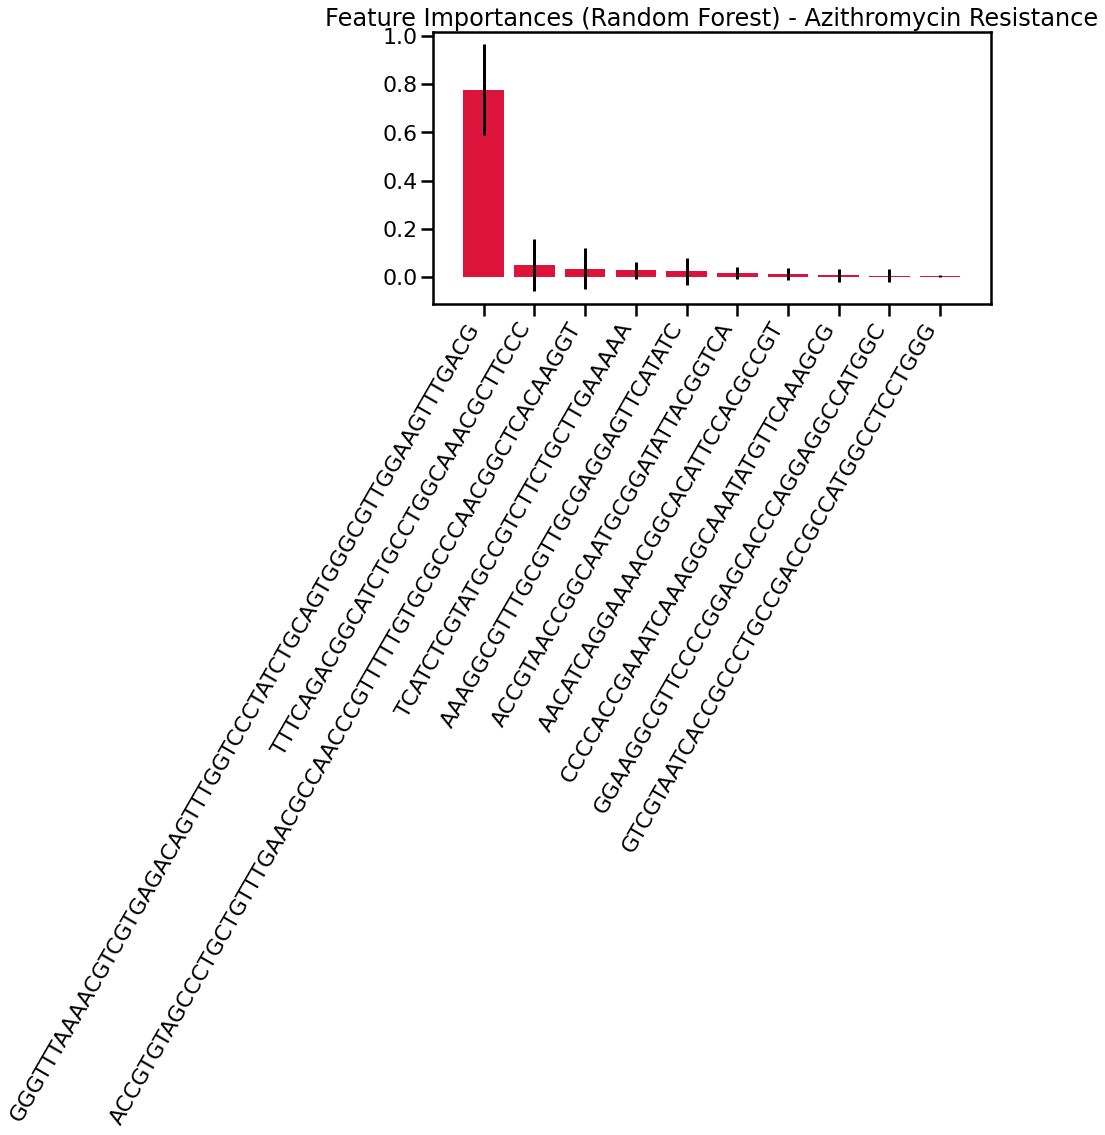

Top predictors:  ['GGGTTTAAAACGTCGTGAGACAGTTTGGTCCCTATCTGCAGTGGGCGTTGGAAGTTTGACG'
 'TTTCAGACGGCATCTGCCTGGCAAACGCTTCCC'
 'ACCGTGTAGCCCTGCTGTTTGAACGCCAACCCGTTTTTGTGCGCCCAACGGCTCACAAGGT'
 'TCATCTCGTATGCCGTCTTCTGCTTGAAAAA' 'AAAGGCGTTTGCGTTGCGAGGAGTTCATATC'
 'ACCGTAACCGGCAATGCGGATATTACGGTCA' 'AACATCAGGAAAACGGCACATTCCACGCCGT'
 'CCCCACCGAAATCAAAGGCAAATATGTTCAAAGCG'
 'GGAAGGCGTTCCCCGGAGCACCCAGGAGGCCATGGC'
 'GTCGTAATCACCGCCCTGCCGACCGCCATGGCCTCCTGGG']


In [16]:
importances = rf_model.best_estimator_.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf_model.best_estimator_.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1][:10]


sb.set_context("poster")
plt.figure(figsize=(10, 5))
plt.title("Feature Importances (Random Forest) - Azithromycin Resistance")
plt.bar(range(10), importances[indices],
       color="crimson", yerr=std[indices], align="center")
plt.xticks(range(10), np.asarray(feature_names)[indices], rotation=60, ha='right')
plt.xlim([-1, 10])
plt.show()

feature_names = list(X.columns)
print("Top predictors: ", np.asarray(feature_names)[indices])

construct a learning curve to see how much performance improves as we include more of our sample set,

In [17]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    sb.set_context("talk")
    plt.figure(figsize=(7, 5))
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Balanced accuracy")
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring="balanced_accuracy")
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid(color='gainsboro')

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="crimson")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="cornflowerblue")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="crimson",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="cornflowerblue",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

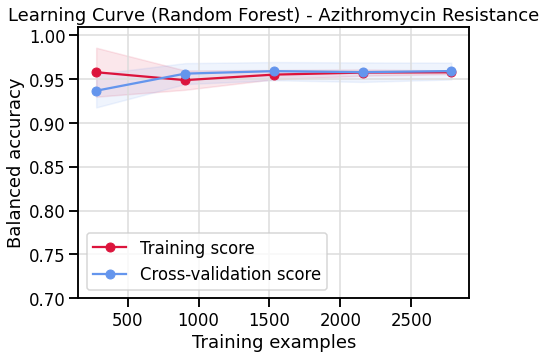

In [18]:
title = "Learning Curve (Random Forest) - Azithromycin Resistance"
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)

estimator = RandomForestClassifier(max_features=round(X.shape[1]*0.5), n_jobs=-1, max_depth=3, n_estimators=50)
plot_learning_curve(estimator, title, X, pheno, ylim=(0.7, 1.01), cv=cv, n_jobs=-1)

plt.show()

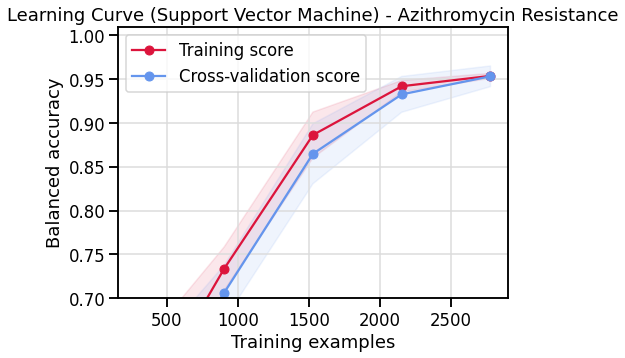

In [19]:
title = "Learning Curve (Support Vector Machine) - Azithromycin Resistance"
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)

estimator = SVC(C=0.01, gamma=1e-06, kernel='linear')
plot_learning_curve(estimator, title, X, pheno, ylim=(0.7, 1.01), cv=cv, n_jobs=-1)

plt.show()

Second, phenotype is **Cefixime**  resistance

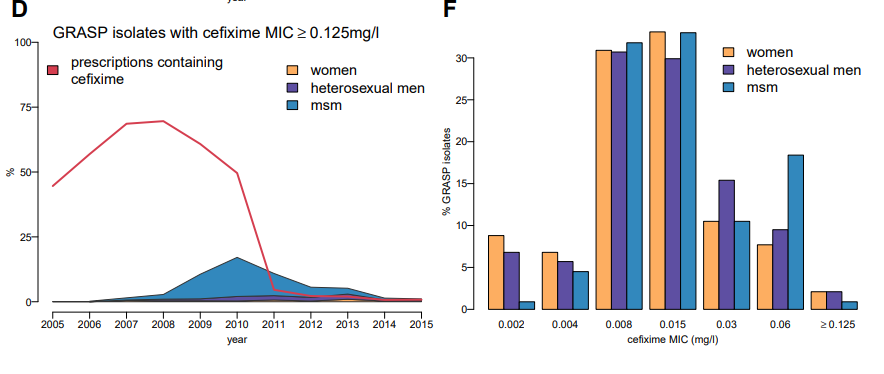

In [20]:
phenotype = 'cfx_sr'
X, pheno = prep_data(phenotype)

performance = []
method = []
times = []

Exploring the data

In [21]:
print(pheno.shape)
print(pheno)

print(X.shape)
print(X.iloc[:10,:10])

(3401,)
Sample_ID
SRR1661154    0.0
SRR1661156    0.0
SRR1661157    0.0
SRR1661158    0.0
SRR1661159    0.0
             ... 
SRR5827366    0.0
SRR5827371    0.0
SRR5827372    0.0
SRR5827369    0.0
SRR5827370    0.0
Name: cfx_sr, Length: 3401, dtype: float64
(3401, 384)
pattern_id  ACCGGTCAGGGCGACGGGTTTGCGCCCTTTGAT  \
SRR1661154                                  0   
SRR1661156                                  0   
SRR1661157                                  0   
SRR1661158                                  0   
SRR1661159                                  0   
SRR1661160                                  0   
SRR1661161                                  0   
SRR1661162                                  0   
SRR1661163                                  0   
SRR1661164                                  0   

pattern_id  TGATACGGCGTGTAGGCGGTGTACCAGCCCGGG  \
SRR1661154                                  0   
SRR1661156                                  0   
SRR1661157                                

The length distribution of the unitigs in our dataset

Index(['ACCGGTCAGGGCGACGGGTTTGCGCCCTTTGAT',
       'TGATACGGCGTGTAGGCGGTGTACCAGCCCGGG',
       'CCGCACGGGGGAAATCCTCGCCTTGGCCAATACGCCCGCCTACGATCCCAACAG',
       'GATATAACTGCGTCCGTCGGCATATTCGCCC',
       'ACCCCGCAACACCTCCTGCTCAACCGCAACGACCTCTTGGTCGGCGG',
       'GGGAAAGGGTAACGTTTGCCGGCGGGGCGGTTGAGGTTGGCGGTT',
       'CAAACTCGAACAGAAAGGCAAGTCGTTTATCTGG', 'AACCGAGCCGGGCGGCACCGGTACGGCGGGT',
       'GCTTGTCGATGTGCCGGTTGATGTTTTGAGAAACAAACTCGAACAGAAA',
       'GACAAATTCTTGGCGGACGATGACGGCAACAGTACCGAGCGCGGCACCCAATGCCAGCGCG'],
      dtype='object', name='pattern_id')


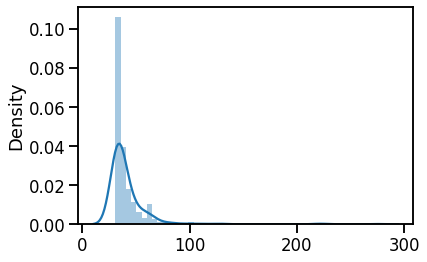

In [22]:
unitigs = X.columns
print(unitigs[:10])
mylen = np.vectorize(len)
uni_len = mylen(unitigs)
sb.distplot(uni_len)

-Building and fitting a model

-call all samples with a predicted value less than or equal to 0.5 as sensitive to the antibiotic

-samples with predicted value >0.5 resistant to the antibiotic

In [23]:
def fitmodel(X, pheno, estimator, parameters, modelname, method, performance, times) :
    
    kfold = KFold(n_splits=5)
    for train_index, test_index in kfold.split(X, pheno):
        #how much time for training
        start = time.process_time()
        
        #splitting data
        X_train = X.iloc[train_index]
        y_train = pheno[train_index]
        X_test = X.iloc[test_index]
        y_test = pheno[test_index]
        
        # grid search to identify best hyper-parameters
        gs_clf = GridSearchCV(estimator=estimator, param_grid=parameters, cv=3, n_jobs=-1, scoring='balanced_accuracy')
        gs_clf.fit(X_train, y_train)
        
        # predict resistance in test
        y_pred = gs_clf.predict(X_test)
        
        y_pred[y_pred<=0.5] = 0
        y_pred[y_pred>0.5] = 1

        score = balanced_accuracy_score(y_test, y_pred)
        performance = np.append(performance, score)
        method = np.append(method, modelname)
        times = np.append(times, (time.process_time() - start))

        print("Best hyperparameters for this fold")
        print(gs_clf.best_params_)
        print("Confusion matrix for this fold")
        print(confusion_matrix(y_test, y_pred))
    return gs_clf, method, performance, times

In [24]:
def sbplot(X, pheno, estimator, parameters, modelname, method, performance, times) :
    results = []
    
    kfold = KFold(n_splits=5)
    for train_index, test_index in kfold.split(X, pheno):
        start = time.process_time()
        
      
        X_train = X.iloc[train_index]
        y_train = pheno[train_index]
        X_test = X.iloc[test_index]
        y_test = pheno[test_index]
        
      
        gs_clf = GridSearchCV(estimator=estimator, param_grid=parameters, cv=3, n_jobs=-1, scoring='balanced_accuracy')
        gs_clf.fit(X_train, y_train)
        
      
        y_pred = gs_clf.predict(X_test)
        
        results.append([y_test, y_pred])
        
    return results

First we will try an elastic net logistic regression

In [25]:
enet = SGDClassifier(loss="log", penalty="elasticnet")
enet_params = {
    'l1_ratio': [0.1, 0.2, 0.5]
}

enet_model, method, performance, times = fitmodel(X, pheno, enet, enet_params, "Elastic net", method, performance, times)

Best hyperparameters for this fold
{'l1_ratio': 0.1}
Confusion matrix for this fold
[[680   0]
 [  1   0]]
Best hyperparameters for this fold
{'l1_ratio': 0.2}
Confusion matrix for this fold
[[680]]
Best hyperparameters for this fold
{'l1_ratio': 0.1}
Confusion matrix for this fold
[[678   0]
 [  2   0]]
Best hyperparameters for this fold
{'l1_ratio': 0.1}
Confusion matrix for this fold
[[680]]
Best hyperparameters for this fold
{'l1_ratio': 0.1}
Confusion matrix for this fold
[[678   0]
 [  2   0]]


Giving support vector machine a try

In [26]:
svm = SVC(class_weight='balanced')
svm_params = {
    'C': [0.01],
    'gamma': [1e-06, 1e-05],
    'kernel': ['linear']
}

svm_model, method, performance, times = fitmodel(X, pheno, svm, svm_params, "Support vector machine", method, performance, times)

Best hyperparameters for this fold
{'C': 0.01, 'gamma': 1e-06, 'kernel': 'linear'}
Confusion matrix for this fold
[[559 121]
 [  0   1]]
Best hyperparameters for this fold
{'C': 0.01, 'gamma': 1e-06, 'kernel': 'linear'}
Confusion matrix for this fold
[[626  54]
 [  0   0]]
Best hyperparameters for this fold
{'C': 0.01, 'gamma': 1e-06, 'kernel': 'linear'}
Confusion matrix for this fold
[[632  46]
 [  1   1]]
Best hyperparameters for this fold
{'C': 0.01, 'gamma': 1e-06, 'kernel': 'linear'}
Confusion matrix for this fold
[[657  23]
 [  0   0]]
Best hyperparameters for this fold
{'C': 0.01, 'gamma': 1e-06, 'kernel': 'linear'}
Confusion matrix for this fold
[[566 112]
 [  1   1]]


Now we will try XGBoost.

In [27]:
xgb_mod = xgb.XGBClassifier(random_state=0)
xgb_params = {
    'alpha': [1e-5, 1e-4], 
    'colsample_bytree': [0.6],
    'gamma': [0.05, 0.1], 
    'learning_rate': [0.01, 0.1], 
    'max_depth': [2], 
    'objective': ['binary:hinge'], 
    'subsample': [0.2, 0.4, 0.6]
}

xgb_model, method, performance, times = fitmodel(X, pheno, xgb_mod, xgb_params, "XGBoost", method, performance, times)

Best hyperparameters for this fold
{'alpha': 1e-05, 'colsample_bytree': 0.6, 'gamma': 0.05, 'learning_rate': 0.01, 'max_depth': 2, 'objective': 'binary:hinge', 'subsample': 0.2}
Confusion matrix for this fold
[[680   0]
 [  1   0]]
Best hyperparameters for this fold
{'alpha': 1e-05, 'colsample_bytree': 0.6, 'gamma': 0.05, 'learning_rate': 0.01, 'max_depth': 2, 'objective': 'binary:hinge', 'subsample': 0.2}
Confusion matrix for this fold
[[680]]
Best hyperparameters for this fold
{'alpha': 1e-05, 'colsample_bytree': 0.6, 'gamma': 0.05, 'learning_rate': 0.01, 'max_depth': 2, 'objective': 'binary:hinge', 'subsample': 0.2}
Confusion matrix for this fold
[[678   0]
 [  2   0]]
Best hyperparameters for this fold
{'alpha': 1e-05, 'colsample_bytree': 0.6, 'gamma': 0.05, 'learning_rate': 0.01, 'max_depth': 2, 'objective': 'binary:hinge', 'subsample': 0.2}
Confusion matrix for this fold
[[680]]
Best hyperparameters for this fold
{'alpha': 1e-05, 'colsample_bytree': 0.6, 'gamma': 0.05, 'learning_

And finally, a random forest.

In [28]:
rf = RandomForestClassifier(random_state=0, n_jobs=-1, class_weight="balanced")
rf_params = {
    'max_features': [round(X.shape[1]*0.1), round(X.shape[1]*0.5), round(X.shape[1]*0.8)],
    'max_depth': [3],
    'n_estimators': [50]
}

rf_model, method, performance, times = fitmodel(X, pheno, rf, rf_params, "Random forest", method, performance, times)

Best hyperparameters for this fold
{'max_depth': 3, 'max_features': 307, 'n_estimators': 50}
Confusion matrix for this fold
[[637  43]
 [  0   1]]
Best hyperparameters for this fold
{'max_depth': 3, 'max_features': 192, 'n_estimators': 50}
Confusion matrix for this fold
[[645  35]
 [  0   0]]
Best hyperparameters for this fold
{'max_depth': 3, 'max_features': 38, 'n_estimators': 50}
Confusion matrix for this fold
[[637  41]
 [  1   1]]
Best hyperparameters for this fold
{'max_depth': 3, 'max_features': 192, 'n_estimators': 50}
Confusion matrix for this fold
[[665  15]
 [  0   0]]
Best hyperparameters for this fold
{'max_depth': 3, 'max_features': 307, 'n_estimators': 50}
Confusion matrix for this fold
[[660  18]
 [  1   1]]


compare results from the different predictors

(array([0, 1, 2, 3]), <a list of 4 Text major ticklabel objects>)

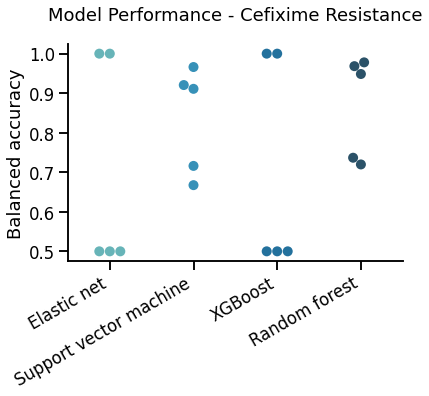

In [29]:
sb.set_context("talk")
plt.title("Model Performance - Cefixime Resistance", y=1.08)
sb.swarmplot(x=method, y=performance, palette="YlGnBu_d", size=10)
sb.despine()
plt.ylabel("Balanced accuracy")
plt.xticks(rotation=30, ha='right')

The time taken to train each model aside

(array([0, 1, 2, 3]), <a list of 4 Text major ticklabel objects>)

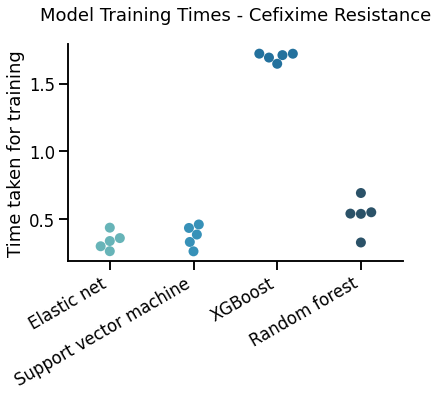

In [30]:
sb.set_context("talk")
plt.title("Model Training Times - Cefixime Resistance", y=1.08)
sb.swarmplot(x=method, y=times, palette="YlGnBu_d", size=10)
sb.despine()
plt.ylabel("Time taken for training")
plt.xticks(rotation=30, ha='right')

looking at SVM feature importance

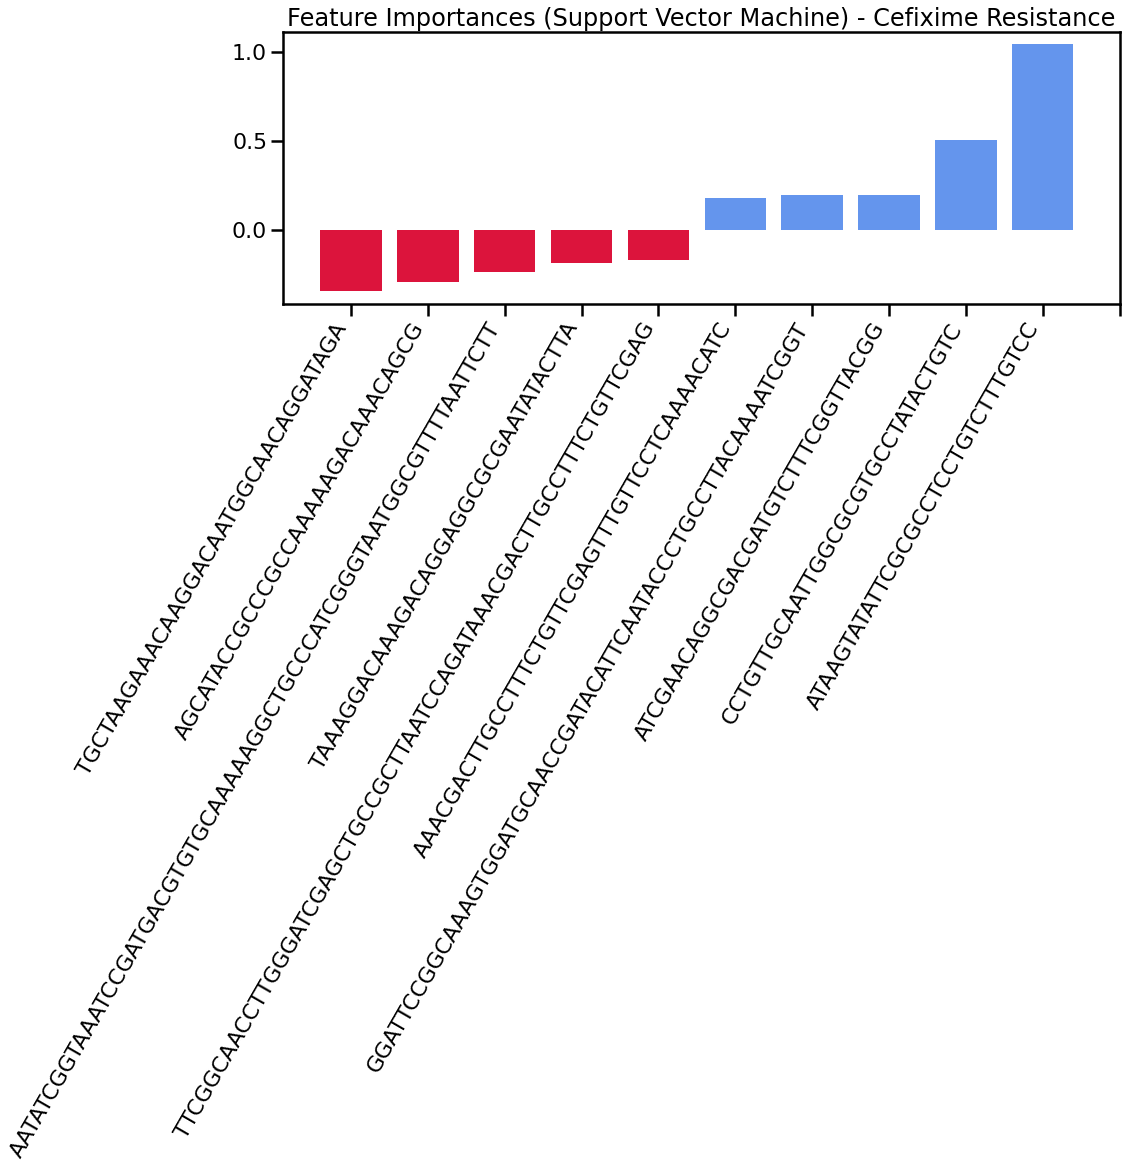

Top negative predictors:  ['TGCTAAGAAACAAGGACAATGGCAACAGGATAGA' 'AGCATACCGCCCGCCAAAAAGACAAACAGCG'
 'AATATCGGTAAATCCGATGACGTGTGCAAAAAGGCTGCCCATCGGGTAATGGCGTTTTAATTCTT'
 'TAAAGGACAAAGACAGGAGGCGCGAATATACTTA'
 'TTCGGCAACCTTGGGATCGAGCTGCCGCTTAATCCAGATAAACGACTTGCCTTTCTGTTCGAG']
Top positive predictors:  ['AAACGACTTGCCTTTCTGTTCGAGTTTGTTCCTCAAAACATC'
 'GGATTCCGGCAAAGTGGATGCAACCGATACATTCAATACCCTGCCTTACAAAATCGGT'
 'ATCGAACAGGCGACGATGTCTTTCGGTTACGG' 'CCTGTTGCAATTGGCGCGTGCCTATACTGTC'
 'ATAAGTATATTCGCGCCTCCTGTCTTTGTCC']


In [31]:
def plot_coefficients(classifier, feature_names, top_features=5):
    coef = classifier.best_estimator_.coef_.ravel()
    top_positive_coefficients = np.argsort(coef)[-top_features:]
    top_negative_coefficients = np.argsort(coef)[:top_features]
    top_coefficients = np.hstack([top_negative_coefficients, top_positive_coefficients])
    # create plot
    sb.set_context("poster")
    plt.figure(figsize=(15, 5))
    plt.title("Feature Importances (Support Vector Machine) - Cefixime Resistance")
    colors = ['crimson' if c < 0 else 'cornflowerblue' for c in coef[top_coefficients]]
    plt.bar(np.arange(2 * top_features), coef[top_coefficients], color=colors)
    feature_names = np.array(feature_names)
    plt.xticks(np.arange(0, 1 + 2 * top_features), feature_names[top_coefficients], rotation=60, ha='right')
    plt.show()
    np.asarray(feature_names)[top_positive_coefficients]

plot_coefficients(svm_model, list(X.columns))
    
# if we print the unitigs, we can then look at what genes they relate to
coef = svm_model.best_estimator_.coef_.ravel()
feature_names = list(X.columns)
top_negative_coefficients = np.argsort(coef)[:5]
print("Top negative predictors: ", np.asarray(feature_names)[top_negative_coefficients])

top_positive_coefficients = np.argsort(coef)[-5:]
print("Top positive predictors: ", np.asarray(feature_names)[top_positive_coefficients])

looking at Random forest feature importance

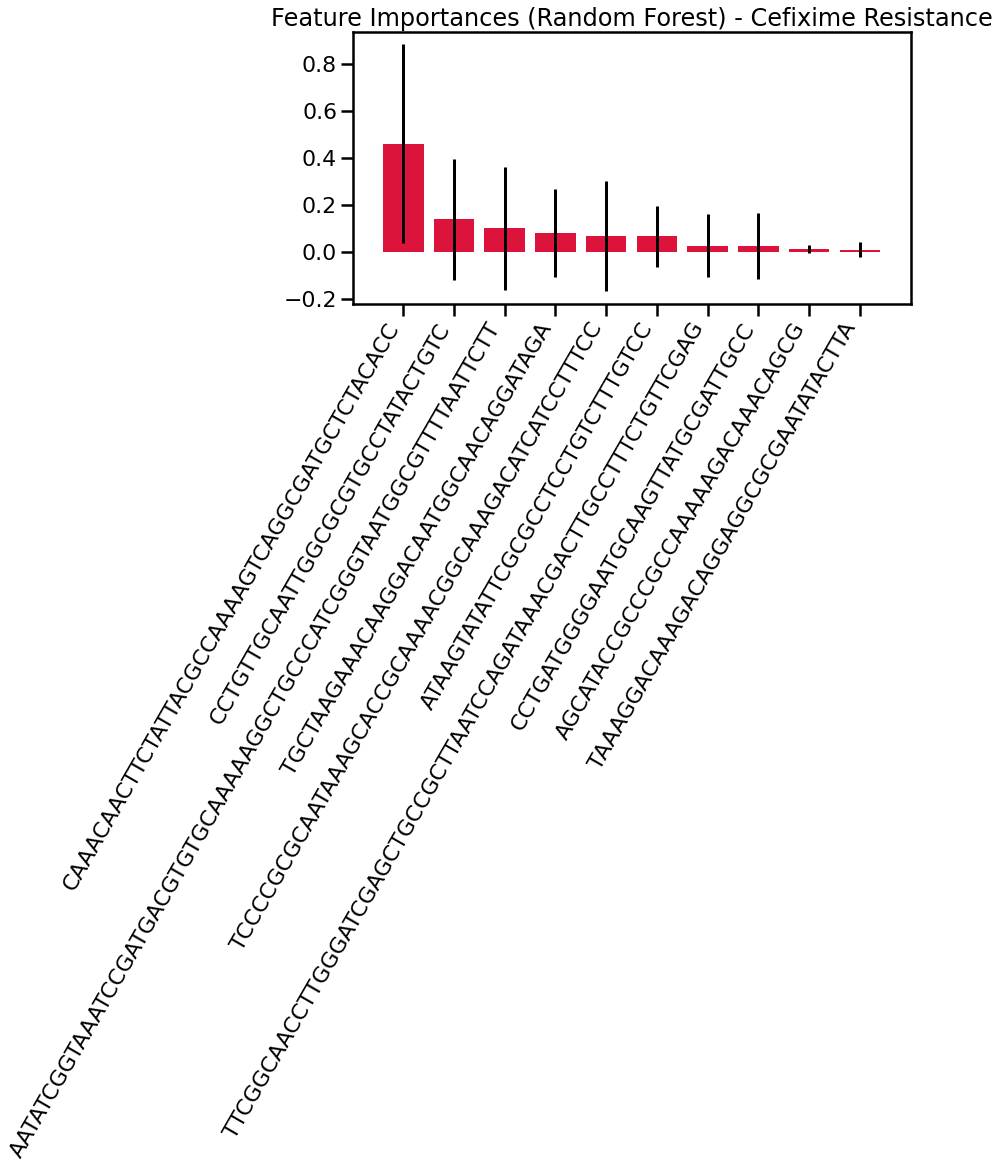

Top predictors:  ['CAAACAACTTCTATTACGCCAAAAGTCAGGCGATGCTCTACACC'
 'CCTGTTGCAATTGGCGCGTGCCTATACTGTC'
 'AATATCGGTAAATCCGATGACGTGTGCAAAAAGGCTGCCCATCGGGTAATGGCGTTTTAATTCTT'
 'TGCTAAGAAACAAGGACAATGGCAACAGGATAGA'
 'TCCCCGCGCAATAAAGCACCGCAAAACGGCAAAGACATCATCCTTTCC'
 'ATAAGTATATTCGCGCCTCCTGTCTTTGTCC'
 'TTCGGCAACCTTGGGATCGAGCTGCCGCTTAATCCAGATAAACGACTTGCCTTTCTGTTCGAG'
 'CCTGATGGGGAATGCAAGTTATGCGATTGCC' 'AGCATACCGCCCGCCAAAAAGACAAACAGCG'
 'TAAAGGACAAAGACAGGAGGCGCGAATATACTTA']


In [32]:
importances = rf_model.best_estimator_.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf_model.best_estimator_.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1][:10]

# Plot the feature importances of the forest
sb.set_context("poster")
plt.figure(figsize=(10, 5))
plt.title("Feature Importances (Random Forest) - Cefixime Resistance")
plt.bar(range(10), importances[indices],
       color="crimson", yerr=std[indices], align="center")
plt.xticks(range(10), np.asarray(feature_names)[indices], rotation=60, ha='right')
plt.xlim([-1, 10])
plt.show()

feature_names = list(X.columns)
print("Top predictors: ", np.asarray(feature_names)[indices])

Third, phenotype is **Ciprofloxacin** resistance 

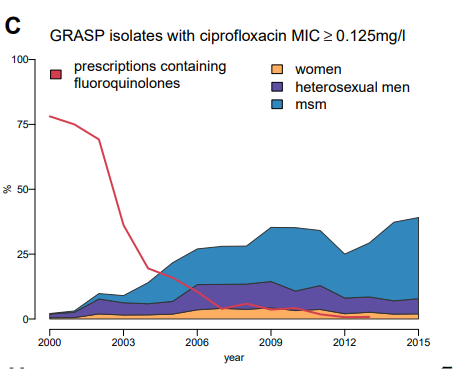

In [36]:
phenotype = 'cip_sr'
X, pheno = prep_data(phenotype)

performance = []
method = []
times = []

Exploring the data

In [37]:
print(pheno.shape)
print(pheno)

print(X.shape)
print(X.iloc[:10,:10])

(3088,)
Sample_ID
SRR1661154    0.0
SRR1661156    1.0
SRR1661157    0.0
SRR1661158    0.0
SRR1661159    0.0
             ... 
SRR5827366    0.0
SRR5827371    0.0
SRR5827372    0.0
SRR5827369    1.0
SRR5827370    0.0
Name: cip_sr, Length: 3088, dtype: float64
(3088, 8873)
pattern_id  ACGTTTATGCCGTTATCGATCCGATAGCCGGT  \
SRR1661154                                 0   
SRR1661156                                 0   
SRR1661157                                 0   
SRR1661158                                 0   
SRR1661159                                 0   
SRR1661160                                 0   
SRR1661161                                 0   
SRR1661162                                 0   
SRR1661163                                 0   
SRR1661164                                 0   

pattern_id  CATCTGCACCCTGTCGGCACTCGCCGCCTGAACCACCCCGTCCGGACAAGG  \
SRR1661154                                                  0     
SRR1661156                                                  0    

The length distribution of the unitigs in our dataset

Index(['ACGTTTATGCCGTTATCGATCCGATAGCCGGT',
       'CATCTGCACCCTGTCGGCACTCGCCGCCTGAACCACCCCGTCCGGACAAGG',
       'CACAAAACTCGTTTCCTGCTCCGAAATGGGCGA,GTAAGGGCTTTCTTAAATTTGATTAAAGGTCGTCTGAA,AACCGAAACCGACCGCGCCGTCGAATATCAGGCGGTCGCACCGGAAGTACG',
       'AAATCTTCCGCTTTAATCCATTTGCCGTCCGA',
       'AAACCTGCCGCAGCCGGCGCATCTTTGGGCGGCGGTCTGGAC,AACGTGGTGTACCAAACCCGCCGTTTCGACCGTTATAAAGAA',
       'CCCAACACACTCGACGTATGGATGAGCCACGGC',
       'TTTTCAACAAAAAACTGCTTGTCCAACGGCAAA',
       'TTTCAACCGGATAGCTGAAAAAACAAAAAAGTTCGATA',
       'CATCACTTCCCGCTGCCGTTTTTTTGTTTCAGACGGCAT',
       'AAACTGCTTGTCCAACGGCAAACCGGCGGGCAGG,CACATAGAAAAGCGGAACAAGGAACACGGATAAAAGCGT,TTTCCTCCGACCATACAGAAGATACCATACGCCTCTCCAAACGTATGG,AGAAAGTGGAATTGAGGAAACCTTTTTATCCGATGAG,TGGATATAGTCTTTTAATTCGTCTTTCGTCGCCCAAGCAGTGCCATAA'],
      dtype='object', name='pattern_id')


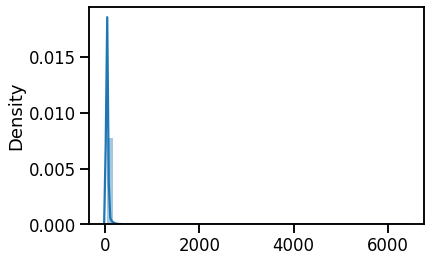

In [38]:
unitigs = X.columns
print(unitigs[:10])
mylen = np.vectorize(len)
uni_len = mylen(unitigs)
sb.distplot(uni_len)

-Building and fitting a model

-Call all samples with a predicted value less than or equal to 0.5 as sensitive to the antibiotic

-Samples with predicted value >0.5 resistant to the antibiotic

In [39]:
def fitmodel(X, pheno, estimator, parameters, modelname, method, performance, times) :
    
    kfold = KFold(n_splits=5)
    for train_index, test_index in kfold.split(X, pheno):
        start = time.process_time()
        
     
        X_train = X.iloc[train_index]
        y_train = pheno[train_index]
        X_test = X.iloc[test_index]
        y_test = pheno[test_index]
        
        gs_clf = GridSearchCV(estimator=estimator, param_grid=parameters, cv=3, n_jobs=-1, scoring='balanced_accuracy')
        gs_clf.fit(X_train, y_train)
          
        y_pred = gs_clf.predict(X_test)
  
        y_pred[y_pred<=0.5] = 0
        y_pred[y_pred>0.5] = 1

        score = balanced_accuracy_score(y_test, y_pred)
        performance = np.append(performance, score)
        method = np.append(method, modelname)
        times = np.append(times, (time.process_time() - start))

        print("Best hyperparameters for this fold")
        print(gs_clf.best_params_)
        print("Confusion matrix for this fold")
        print(confusion_matrix(y_test, y_pred))
    return gs_clf, method, performance, times

In [40]:
def sbplot(X, pheno, estimator, parameters, modelname, method, performance, times) :
    results = []
    
    kfold = KFold(n_splits=5)
    for train_index, test_index in kfold.split(X, pheno):
        start = time.process_time()
        
        X_train = X.iloc[train_index]
        y_train = pheno[train_index]
        X_test = X.iloc[test_index]
        y_test = pheno[test_index]
        
        gs_clf = GridSearchCV(estimator=estimator, param_grid=parameters, cv=3, n_jobs=-1, scoring='balanced_accuracy')
        gs_clf.fit(X_train, y_train)
        
        y_pred = gs_clf.predict(X_test)
        
        results.append([y_test, y_pred])
        
    return results

First we will try an elastic net logistic regression.

In [41]:
enet = SGDClassifier(loss="log", penalty="elasticnet")
enet_params = {
    'l1_ratio': [0.1, 0.2, 0.5]
}

enet_model, method, performance, times = fitmodel(X, pheno, enet, enet_params, "Elastic net", method, performance, times)

Best hyperparameters for this fold
{'l1_ratio': 0.5}
Confusion matrix for this fold
[[314   7]
 [  9 288]]
Best hyperparameters for this fold
{'l1_ratio': 0.2}
Confusion matrix for this fold
[[336  15]
 [ 12 255]]
Best hyperparameters for this fold
{'l1_ratio': 0.5}
Confusion matrix for this fold
[[294  32]
 [ 30 262]]
Best hyperparameters for this fold
{'l1_ratio': 0.1}
Confusion matrix for this fold
[[334   0]
 [ 15 268]]
Best hyperparameters for this fold
{'l1_ratio': 0.2}
Confusion matrix for this fold
[[321   7]
 [ 21 268]]


Giving support vector machine a try

In [42]:
svm = SVC(class_weight='balanced')
svm_params = {
    'C': [0.01],
    'gamma': [1e-06, 1e-05],
    'kernel': ['linear']
}

svm_model, method, performance, times = fitmodel(X, pheno, svm, svm_params, "Support vector machine", method, performance, times)

Best hyperparameters for this fold
{'C': 0.01, 'gamma': 1e-06, 'kernel': 'linear'}
Confusion matrix for this fold
[[312   9]
 [  5 292]]
Best hyperparameters for this fold
{'C': 0.01, 'gamma': 1e-06, 'kernel': 'linear'}
Confusion matrix for this fold
[[337  14]
 [ 12 255]]
Best hyperparameters for this fold
{'C': 0.01, 'gamma': 1e-06, 'kernel': 'linear'}
Confusion matrix for this fold
[[283  43]
 [ 17 275]]
Best hyperparameters for this fold
{'C': 0.01, 'gamma': 1e-06, 'kernel': 'linear'}
Confusion matrix for this fold
[[334   0]
 [ 15 268]]
Best hyperparameters for this fold
{'C': 0.01, 'gamma': 1e-06, 'kernel': 'linear'}
Confusion matrix for this fold
[[321   7]
 [ 23 266]]


Now we will try XGBoost.

In [43]:
xgb_mod = xgb.XGBClassifier(random_state=0)
xgb_params = {
    'alpha': [1e-5, 1e-4], 
    'colsample_bytree': [0.6],
    'gamma': [0.05, 0.1], 
    'learning_rate': [0.01, 0.1], 
    'max_depth': [2], 
    'objective': ['binary:hinge'], 
    'subsample': [0.2, 0.4, 0.6]
}

xgb_model, method, performance, times = fitmodel(X, pheno, xgb_mod, xgb_params, "XGBoost", method, performance, times)

Best hyperparameters for this fold
{'alpha': 1e-05, 'colsample_bytree': 0.6, 'gamma': 0.05, 'learning_rate': 0.01, 'max_depth': 2, 'objective': 'binary:hinge', 'subsample': 0.2}
Confusion matrix for this fold
[[304  17]
 [  0 297]]
Best hyperparameters for this fold
{'alpha': 1e-05, 'colsample_bytree': 0.6, 'gamma': 0.05, 'learning_rate': 0.1, 'max_depth': 2, 'objective': 'binary:hinge', 'subsample': 0.6}
Confusion matrix for this fold
[[337  14]
 [ 14 253]]
Best hyperparameters for this fold
{'alpha': 1e-05, 'colsample_bytree': 0.6, 'gamma': 0.05, 'learning_rate': 0.1, 'max_depth': 2, 'objective': 'binary:hinge', 'subsample': 0.6}
Confusion matrix for this fold
[[280  46]
 [  2 290]]
Best hyperparameters for this fold
{'alpha': 1e-05, 'colsample_bytree': 0.6, 'gamma': 0.05, 'learning_rate': 0.1, 'max_depth': 2, 'objective': 'binary:hinge', 'subsample': 0.6}
Confusion matrix for this fold
[[334   0]
 [ 15 268]]
Best hyperparameters for this fold
{'alpha': 1e-05, 'colsample_bytree': 0.6

And finally, a random forest.

In [52]:
rf = RandomForestClassifier(random_state=0, n_jobs=-1, class_weight="balanced")
rf_params = {
    'max_features': [round(X.shape[1]*0.1), round(X.shape[1]*0.5), round(X.shape[1]*0.8)],
    'max_depth': [3],
    'n_estimators': [50]
}

rf_model, method, performance, times = fitmodel(X, pheno, rf, rf_params, "Random forest", method, performance, times)

Best hyperparameters for this fold
{'max_depth': 3, 'max_features': 4436, 'n_estimators': 50}
Confusion matrix for this fold
[[311  10]
 [  4 293]]
Best hyperparameters for this fold
{'max_depth': 3, 'max_features': 4436, 'n_estimators': 50}
Confusion matrix for this fold
[[338  13]
 [ 13 254]]
Best hyperparameters for this fold
{'max_depth': 3, 'max_features': 887, 'n_estimators': 50}
Confusion matrix for this fold
[[290  36]
 [ 12 280]]
Best hyperparameters for this fold
{'max_depth': 3, 'max_features': 4436, 'n_estimators': 50}
Confusion matrix for this fold
[[330   4]
 [  3 280]]
Best hyperparameters for this fold
{'max_depth': 3, 'max_features': 4436, 'n_estimators': 50}
Confusion matrix for this fold
[[321   7]
 [ 20 269]]


Compare results from the different predictors

(array([0, 1, 2, 3]), <a list of 4 Text major ticklabel objects>)

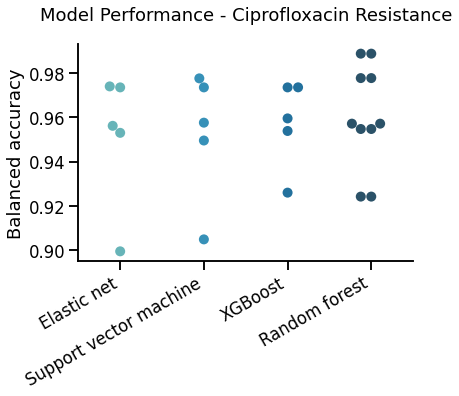

In [58]:
sb.set_context("talk")
plt.title("Model Performance - Ciprofloxacin Resistance", y=1.08)
sb.swarmplot(x=method, y=performance, palette="YlGnBu_d", size=10)
sb.despine()
plt.ylabel("Balanced accuracy")
plt.xticks(rotation=30, ha='right')

The time taken to train each model aside

(array([0, 1, 2, 3]), <a list of 4 Text major ticklabel objects>)

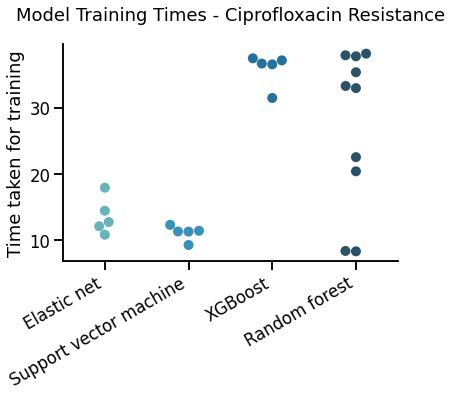

In [53]:
sb.set_context("talk")
plt.title("Model Training Times - Ciprofloxacin Resistance", y=1.08)
sb.swarmplot(x=method, y=times, palette="YlGnBu_d", size=10)
sb.despine()
plt.ylabel("Time taken for training")
plt.xticks(rotation=30, ha='right')

Looking at SVM feature importance

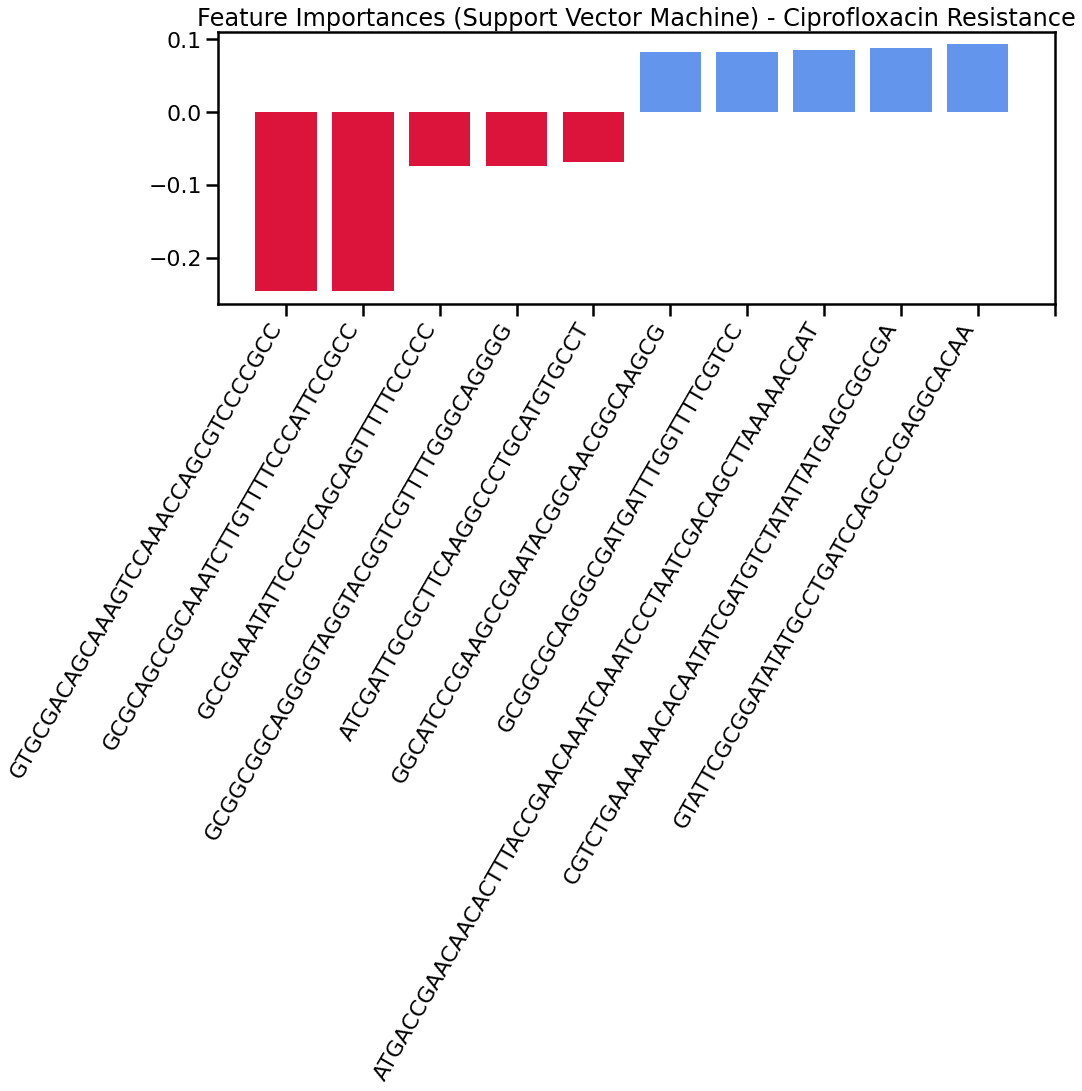

Top negative predictors:  ['GTGCGACAGCAAAGTCCAAACCAGCGTCCCCGCC' 'GCGCAGCCGCAAATCTTGTTTTCCCATTCCGCC'
 'GCCGAAATATTCCGTCAGCAGTTTTTCCCCC'
 'GCGGCGGCAGGGGTAGGTACGGTCGTTTTGGGCAGGGG'
 'ATCGATTGCGCTTCAAGGCCCTGCATGTGCCT']
Top positive predictors:  ['GGCATCCCGAAGCCGAATACGGCAACGGCAAGCG' 'GCGGCGCAGGGCGATGATTTGGTTTTCGTCC'
 'ATGACCGAACAACACTTTACCGAACAAATCAAATCCCTAATCGACAGCTTAAAAACCAT'
 'CGTCTGAAAAAACACAATATCGATGTCTATATTATGAGCGGCGA'
 'GTATTCGCGGATATATGCCTGATCCAGCCCGAGGCACAA']


In [54]:
def plot_coefficients(classifier, feature_names, top_features=5):
    coef = classifier.best_estimator_.coef_.ravel()
    top_positive_coefficients = np.argsort(coef)[-top_features:]
    top_negative_coefficients = np.argsort(coef)[:top_features]
    top_coefficients = np.hstack([top_negative_coefficients, top_positive_coefficients])
    # create plot
    sb.set_context("poster")
    plt.figure(figsize=(15, 5))
    plt.title("Feature Importances (Support Vector Machine) - Ciprofloxacin Resistance")
    colors = ['crimson' if c < 0 else 'cornflowerblue' for c in coef[top_coefficients]]
    plt.bar(np.arange(2 * top_features), coef[top_coefficients], color=colors)
    feature_names = np.array(feature_names)
    plt.xticks(np.arange(0, 1 + 2 * top_features), feature_names[top_coefficients], rotation=60, ha='right')
    plt.show()
    np.asarray(feature_names)[top_positive_coefficients]

plot_coefficients(svm_model, list(X.columns))
    
# if we print the unitigs, we can then look at what genes they relate to
coef = svm_model.best_estimator_.coef_.ravel()
feature_names = list(X.columns)
top_negative_coefficients = np.argsort(coef)[:5]
print("Top negative predictors: ", np.asarray(feature_names)[top_negative_coefficients])

top_positive_coefficients = np.argsort(coef)[-5:]
print("Top positive predictors: ", np.asarray(feature_names)[top_positive_coefficients])

Looking at Random forest feature importance

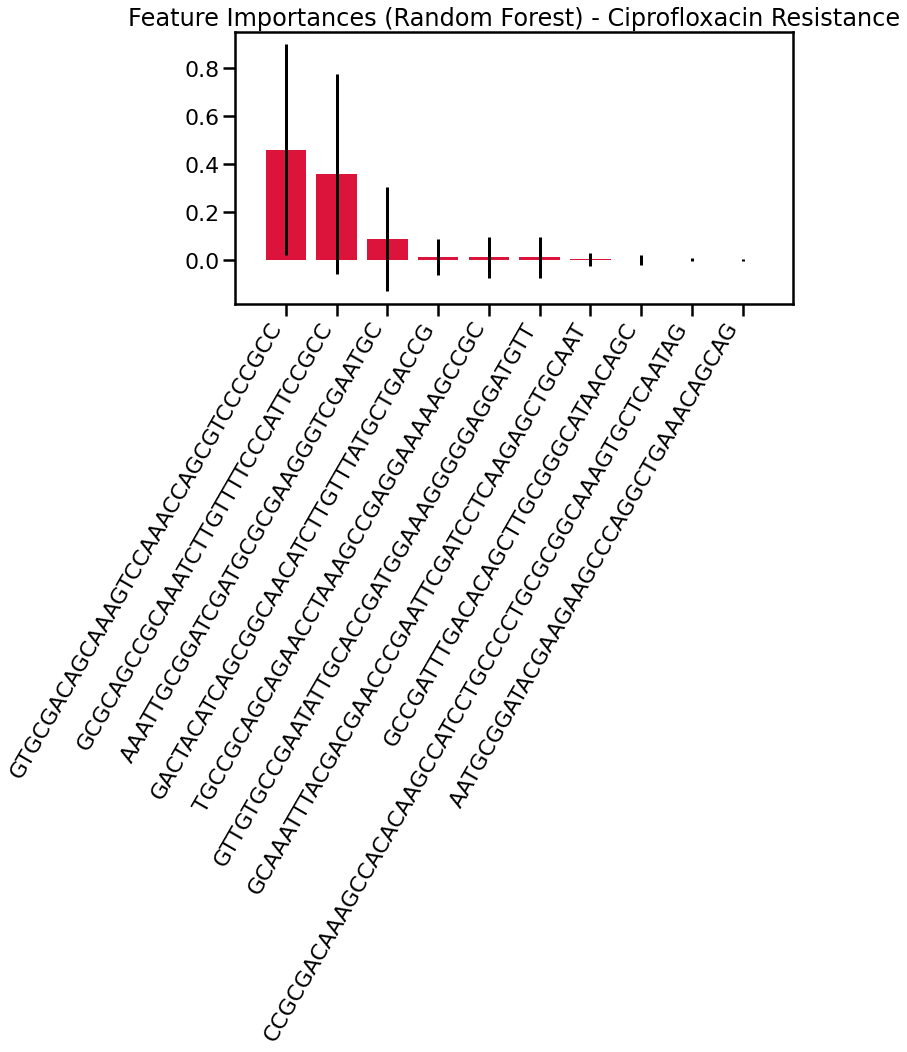

Top predictors:  ['GTGCGACAGCAAAGTCCAAACCAGCGTCCCCGCC' 'GCGCAGCCGCAAATCTTGTTTTCCCATTCCGCC'
 'AAATTGCGGATCGATGCGCGAAGGGTCGAATGC'
 'GACTACATCAGCGGCAACATCTTGTTTATGCTGACCG'
 'TGCCGCAGCAGAACCTAAAGCCGAGGAAAAAGCCGC'
 'GTTGTGCCGAATATTGCACCGATGGAAAGGGGGAGGATGTT'
 'GCAAATTTACGACGAACCCGAATTCGATCCTCAAGAGCTGCAAT'
 'GCCGATTTGACACAGCTTGCGGGCATAACAGC'
 'CCGCGACAAAGCCACACAAGCCATCCTGCCCCTGCGCGGCAAAGTGCTCAATAG'
 'AATGCGGATACGAAGAAGCCCAGGCTGAAACAGCAG']


In [55]:
importances = rf_model.best_estimator_.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf_model.best_estimator_.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1][:10]

# Plot the feature importances of the forest
sb.set_context("poster")
plt.figure(figsize=(10, 5))
plt.title("Feature Importances (Random Forest) - Ciprofloxacin Resistance")
plt.bar(range(10), importances[indices],
       color="crimson", yerr=std[indices], align="center")
plt.xticks(range(10), np.asarray(feature_names)[indices], rotation=60, ha='right')
plt.xlim([-1, 10])
plt.show()

feature_names = list(X.columns)
print("Top predictors: ", np.asarray(feature_names)[indices])

Construct a learning curve to see how much performance improves as we include more of our sample set,

In [56]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    sb.set_context("talk")
    plt.figure(figsize=(7, 5))
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Balanced accuracy")
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring="balanced_accuracy")
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid(color='gainsboro')

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="crimson")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="cornflowerblue")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="crimson",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="cornflowerblue",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

Learning curve Random forest

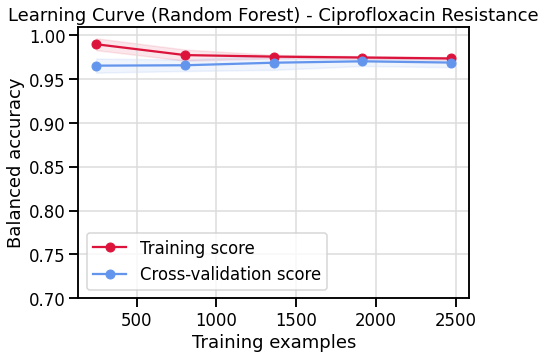

In [57]:
title = "Learning Curve (Random Forest) - Ciprofloxacin Resistance"
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)

estimator = RandomForestClassifier(max_features=round(X.shape[1]*0.5), n_jobs=-1, max_depth=3, n_estimators=50)
plot_learning_curve(estimator, title, X, pheno, ylim=(0.7, 1.01), cv=cv, n_jobs=-1)

plt.show()

learning curve Support vector machine

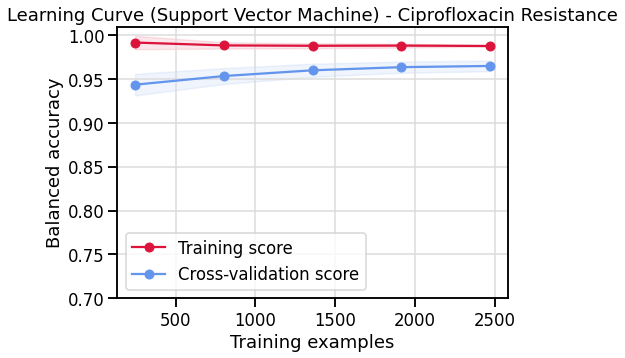

In [59]:
title = "Learning Curve (Support Vector Machine) - Ciprofloxacin Resistance"
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)

estimator = SVC(C=0.01, gamma=1e-06, kernel='linear')
plot_learning_curve(estimator, title, X, pheno, ylim=(0.7, 1.01), cv=cv, n_jobs=-1)

plt.show()